<a href="https://colab.research.google.com/github/MALLIKARJUN660/MALLIKARJUN660/blob/main/Predicting_RUL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(42)
n = 1000

# Helper to round floats to at most two decimals
r2 = lambda x: np.round(x, 2)

# Base distributions
cycle_index = rng.integers(1, 1200, size=n)  # integer
dod = r2(rng.uniform(60, 100, size=n))       # % of full
max_soc = r2(rng.uniform(95, 100, size=n))
min_soc = r2(np.clip(max_soc - dod, 0, 95))
c_rate_chg = r2(rng.uniform(0.3, 2.0, size=n))
c_rate_dis = r2(rng.uniform(0.5, 3.0, size=n))

soc_mean = r2(rng.uniform(20, 90, size=n))
voltage_mean = r2(rng.uniform(3.4, 4.1, size=n))
current_mean = r2(rng.uniform(2, 120, size=n))  # A, pack-level proxy

ambient_temp = r2(rng.normal(25, 7, size=n))    # °C
battery_temp = r2(ambient_temp + rng.normal(5, 4, size=n))  # °C

# Charging duration in minutes (two decimals max)
charging_min = r2(rng.uniform(20, 120, size=n))

efficiency = r2(np.clip(rng.normal(98, 0.5, size=n), 96.5, 99.5))

# Cell/context (fixed for your spec)
cell_capacity_Ah = r2(rng.uniform(2.5, 3.4, size=n))  # adjust if needed
cathode = np.array(["NMC"] * n)
anode = np.array(["Graphite"] * n)
cell_type = np.array(["Cylindrical"] * n)

# --- SOH model (simple but plausible) ---
# Start near 1.0 and degrade with cycles, temperature stress, C-rate, and DOD
temp_stress = np.clip((battery_temp - 25) / 15, -1, 3)  # >25°C accelerates, <25 helps
rate_stress = 0.15 * (c_rate_chg - 0.5) + 0.1 * (c_rate_dis - 1.0)
dod_stress = (dod - 80) / 40  # higher DOD → more stress

base_fade_per_cycle = 3e-4  # 0.03%/cycle baseline (tune as needed)
fade_factor = np.clip(1 + 0.6*temp_stress + 0.4*rate_stress + 0.5*dod_stress, 0.2, 3.0)
soh = np.clip(1.0 - base_fade_per_cycle * fade_factor * cycle_index
              + rng.normal(0, 0.01, size=n), 0.5, 1.0)
soh_pct = r2(soh * 100)

# --- RUL model consistent with SOH ---
# Predict cycles until SOH hits 80% threshold, using current fade rate estimate.
fade_rate_now = np.clip(base_fade_per_cycle * fade_factor, 1e-5, 1e-2)
cycles_to_80 = np.clip((0.80 - soh) / (-fade_rate_now), 0, 2000)
rul = np.maximum(0, np.floor(cycles_to_80)).astype(int)  # integer RUL

# Optional: small fraction of outliers for realism
mask = rng.random(n) < 0.05
battery_temp[mask] = r2(battery_temp[mask] + rng.normal(20, 5, size=mask.sum()))
efficiency[mask] = r2(np.clip(efficiency[mask] - rng.uniform(1, 2, size=mask.sum()), 94, 99))
soh_pct = r2(np.clip(soh_pct, 50, 100))

df = pd.DataFrame({
    "Cycle_Index": cycle_index,
    "DOD (%)": dod,
    "Max_SOC (%)": max_soc,
    "Min_SOC (%)": min_soc,
    "Charge C-rate": c_rate_chg,
    "Discharge C-rate": c_rate_dis,
    "SOC_mean (%)": soc_mean,
    "Voltage_mean (V)": voltage_mean,
    "Current_mean (A)": current_mean,
    "Battery_Temp_mean (°C)": battery_temp,
    "Ambient_Temp_mean (°C)": ambient_temp,
    "Charging_Duration_min (min)": charging_min,
    "Efficiency (%)": efficiency,
    "cell_capacity_Ah": cell_capacity_Ah,
    "Cathode": cathode,
    "Anode": anode,
    "Cell_Type": cell_type,
    "SOH (%)": soh_pct,   # feature
    "RUL (cycles)": rul    # target
})

df.to_csv("EV_RUL_practical_dataset.csv", index=False)
print("Saved: EV_RUL_practical_dataset.csv")


Saved: EV_RUL_practical_dataset.csv


In [ ]:
from google.colab import files
files.download("EV_RUL_practical_dataset.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files

# Number of cycles (2W EV battery life)
total_cycles = 1500

# Generate cycle numbers
cycles = np.arange(1, total_cycles+1)

# Simulated realistic parameters
voltage = np.random.normal(3.7, 0.05, total_cycles) - (cycles/total_cycles * 0.3)  # slight drop
current = np.random.normal(2.0, 0.2, total_cycles)  # discharge current (A)
capacity = 2.5 - (cycles/total_cycles * 0.6) + np.random.normal(0, 0.05, total_cycles)  # Ah, degrading
soh = 100 - (cycles/total_cycles * 30) + np.random.normal(0, 0.5, total_cycles)  # % degrading from 100 → ~70
rul = total_cycles - cycles  # Remaining useful life (cycles left)
internal_resistance = 0.05 + (cycles/total_cycles * 0.02) + np.random.normal(0, 0.002, total_cycles)  # ohm
battery_temp = np.random.normal(30, 2, total_cycles) + (cycles/total_cycles * 5)  # °C
ambient_temp = np.random.normal(28, 3, total_cycles)  # °C
charging_time_min = np.random.normal(90, 5, total_cycles) + (cycles/total_cycles * 20)  # minutes

# Create dataset
data = {
    "Cycle": cycles,
    "Voltage (V)": voltage.round(2),
    "Current (A)": current.round(2),
    "Capacity (Ah)": capacity.round(2),
    "SOH (%)": soh.round(2),
    "Internal Resistance (Ω)": internal_resistance.round(4),
    "Battery Temp (°C)": battery_temp.round(2),
    "Ambient Temp (°C)": ambient_temp.round(2),
    "Charging Time (min)": charging_time_min.round(1),
    "RUL (cycles)": rul
}

df = pd.DataFrame(data)

# Save to CSV
df.to_csv("2W_EV_Battery_RUL.csv", index=False)

# Download CSV
files.download("2W_EV_Battery_RUL.csv")

# Show first 10 rows
df.head(10)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Cycle,Voltage (V),Current (A),Capacity (Ah),SOH (%),Internal Resistance (Ω),Battery Temp (°C),Ambient Temp (°C),Charging Time (min),RUL (cycles)
0,1,3.65,1.83,2.44,100.69,0.0490,31.39,26.74,100.4,1499
1,2,3.70,2.19,2.51,99.41,0.0533,33.86,31.73,86.6,1498
2,3,3.71,1.96,2.50,100.37,0.0494,31.40,28.61,93.9,1497
3,4,3.76,2.10,2.56,99.92,0.0480,32.07,29.76,91.2,1496
4,5,3.73,2.13,2.46,99.60,0.0547,26.19,25.24,92.3,1495
5,6,3.65,1.81,2.55,99.42,0.0468,33.07,35.13,87.3,1494
6,7,3.64,2.62,2.53,99.98,0.0486,30.94,29.05,98.1,1493
7,8,3.77,2.05,2.41,99.22,0.0511,29.43,31.78,82.7,1492
8,9,3.72,2.03,2.43,100.74,0.0530,29.94,29.37,93.4,1491
9,10,3.81,2.07,2.48,99.89,0.0472,34.68,30.85,87.1,1490


In [ ]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Battery specs (2-wheeler EV, 1500 cycles)
total_cycles = 1500
initial_capacity = 2.5  # Ah
eol_capacity = 1.8      # End of life capacity (Ah, ~70-75% of initial)

# Create empty dataframe
data = []

for cycle in range(1, total_cycles + 1):
    # Capacity fade (linear + random noise)
    capacity = initial_capacity - (cycle/total_cycles) * (initial_capacity - eol_capacity)
    capacity += np.random.normal(0, 0.01)  # small noise

    # SOH (%)
    soh = (capacity / initial_capacity) * 100

    # RUL (cycles left)
    rul = total_cycles - cycle

    # Voltage (simulate average per cycle, 3.2V–4.2V range)
    voltage = np.random.uniform(3.2, 4.2)

    # Current (discharge ~1-2C, charge ~0.5-1C)
    current = np.random.uniform(1, 5)

    # SOC (%), assume mid-range cycling
    soc = np.random.uniform(20, 100)

    # Temperature
    ambient_temp = np.random.uniform(20, 35)   # °C, typical India conditions
    battery_temp = ambient_temp + np.random.uniform(2, 10)  # slightly higher than ambient

    # Internal resistance (grows with aging)
    resistance = 30 + (cycle/total_cycles) * 20  # mΩ

    # Time parameters
    charge_time = np.random.uniform(40, 80) + (cycle/total_cycles) * 10  # min
    discharge_time = (capacity / initial_capacity) * np.random.uniform(60, 120)  # min

    # Append row
    data.append([
        cycle, rul, voltage, current, capacity, soc, soh,
        battery_temp, ambient_temp, resistance, charge_time, discharge_time
    ])

# Convert to DataFrame
columns = [
    "Cycle_Index", "RUL", "Voltage(V)", "Current(A)", "Capacity(Ah)", "SOC(%)", "SOH(%)",
    "Battery_Temperature(°C)", "Ambient_Temperature(°C)", "Internal_Resistance(mΩ)",
    "Charge_Time(min)", "Discharge_Time(min)"
]
df = pd.DataFrame(data, columns=columns)

# Save to CSV
df.to_csv("EV_2Wheeler_Battery_RUL_Dataset.csv", index=False)

# Show first 10 rows
df.head(10)


,Cycle_Index,RUL,Voltage(V),Current(A),Capacity(Ah),SOC(%),SOH(%),Battery_Temperature(°C),Ambient_Temperature(°C),Internal_Resistance(mΩ),Charge_Time(min),Discharge_Time(min)
0,1,1499,3.931994,3.394634,2.504500,32.481491,100.180019,24.804587,22.339918,30.013333,74.653712,96.239839
1,2,1498,3.908073,1.082338,2.497684,97.592788,99.907361,36.185352,32.486640,30.026667,47.286332,70.938493
2,3,1497,3.631945,2.164917,2.501020,68.948232,100.040785,26.429565,22.092408,30.040000,54.674474,87.399830
3,4,1496,3.985176,1.798695,2.479001,61.138755,99.160021,31.257822,28.886219,30.053333,64.328461,69.641518
4,5,1495,3.884233,2.760610,2.491660,29.763059,99.666411,29.702762,27.427654,30.066667,76.406149,75.274850
5,6,1494,3.862522,2.246844,2.494283,61.605442,99.771323,31.679490,28.200654,30.080000,78.823385,106.264410
6,7,1493,3.288493,1.783931,2.504118,23.618183,100.164720,29.989373,24.879955,30.093333,50.900628,109.904988
7,8,1492,3.556753,2.123738,2.497980,63.415687,99.919214,30.531439,22.113863,30.106667,43.035359,119.116909
8,9,1491,3.205522,4.261846,2.489031,76.548588,99.561231,39.105270,30.935108,30.120000,43.021786,81.150312
9,10,1490,3.315869,4.452414,2.501450,69.863850,100.058004,27.471937,24.963470,30.133333,52.505960,79.557119


In [ ]:
from google.colab import files
files.download("EV_2Wheeler_Battery_RUL_Dataset.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import pandas as pd
import json
import random

# -----------------------------
# CONFIG
# -----------------------------
num_vehicles = 10        # Number of 2-wheeler EVs
max_cycles = 1500        # Each battery lasts up to 1500 cycles
np.random.seed(42)

# Store cycle-by-cycle data
all_data = []

# Store per-vehicle metadata
metadata = {}

# -----------------------------
# SIMULATION
# -----------------------------
for v in range(1, num_vehicles + 1):
    vehicle_id = f"Vehicle_{v}"

    # Vehicle-specific "true" parameters
    init_capacity = round(np.random.normal(50, 1.0), 2)   # Ah
    init_resistance = round(np.random.normal(20, 0.8), 2) # mΩ

    # Randomize End-of-Life cycle (between 1300 and 1500)
    eol_cycle = random.randint(1300, max_cycles)

    # Save metadata
    metadata[vehicle_id] = {
        "Initial_Capacity_Ah": init_capacity,
        "Initial_Resistance_mOhm": init_resistance,
        "End_of_Life_Cycle": eol_cycle
    }

    # Simulate cycle data
    capacity = init_capacity
    resistance = init_resistance

    for cycle in range(1, max_cycles + 1):
        # Capacity fade (non-linear, slightly noisy)
        degradation = 0.0003 * (cycle ** 0.9) + np.random.normal(0, 0.005)
        capacity = max(0, init_capacity - degradation * cycle)

        # Resistance growth
        resistance = init_resistance + 0.002 * (cycle ** 0.5) + np.random.normal(0, 0.05)

        # SOH (State of Health)
        soh = (capacity / init_capacity) * 100

        # Temperature profile (25–40°C with variation)
        temperature = round(np.random.normal(30 + 0.002*cycle, 2), 2)

        # Voltage range
        voltage = round(np.random.uniform(3.0, 4.2), 2)

        # Current (± based on charge/discharge)
        current = round(np.random.uniform(-50, 50), 2)

        # Stop if EOL is reached (SOH < 80%)
        if cycle > eol_cycle or soh < 80:
            break

        all_data.append([
            vehicle_id, cycle, round(capacity, 3), round(resistance, 3),
            round(soh, 2), temperature, voltage, current
        ])

# -----------------------------
# SAVE OUTPUTS
# -----------------------------
# Save dataset
df = pd.DataFrame(all_data, columns=[
    "Vehicle_ID", "Cycle", "Capacity_Ah", "Resistance_mOhm",
    "SOH_percent", "Temperature_C", "Voltage_V", "Current_A"
])
df.to_csv("battery_dataset.csv", index=False)

# Save metadata
with open("metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print("✅ Dataset and Metadata Generated Successfully!")


✅ Dataset and Metadata Generated Successfully!


In [ ]:
from google.colab import files
files.download("battery_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np

# Parameters
num_cycles = 1500
vehicle_id = "EV_001"

# Generate synthetic dataset
np.random.seed(42)  # For reproducibility

data = {
    "Cycle_Index": np.arange(1, num_cycles + 1),
    "Vehicle_ID": [vehicle_id] * num_cycles,
    "SoC": np.linspace(100, 20, num_cycles),  # State of Charge decreases with cycles
    "SoH": np.linspace(100, 60, num_cycles),  # State of Health decreases with cycles
    "Capacity": np.linspace(50, 30, num_cycles),  # Capacity fade
    "V_min": np.random.normal(3.2, 0.05, num_cycles),  # Min voltage
    "V_max": np.random.normal(4.2, 0.05, num_cycles),  # Max voltage
    "R_int": np.linspace(20, 80, num_cycles),  # Internal resistance increases
    "I_chg": np.random.normal(50, 2, num_cycles),  # Charging current
    "I_dis": np.random.normal(45, 2, num_cycles),  # Discharging current
    "T_chg": np.linspace(60, 90, num_cycles),  # Charging time increases
    "T_dis": np.linspace(80, 50, num_cycles),  # Discharging time decreases
    "Batt_Temp": np.random.normal(28, 3, num_cycles),  # Battery temperature
    "Amb_Temp": np.random.normal(30, 5, num_cycles),  # Ambient temperature
    "DoD": np.random.uniform(80, 100, num_cycles),  # Depth of discharge
    "EIS_f1": np.random.uniform(0.010, 0.020, num_cycles),  # Impedance feature 1
    "EIS_f2": np.random.uniform(0.015, 0.025, num_cycles),  # Impedance feature 2
    "EIS_f3": np.random.uniform(0.020, 0.030, num_cycles),  # Impedance feature 3
    "RUL": np.arange(num_cycles - 1, -1, -1)  # Remaining Useful Life
}

df = pd.DataFrame(data)

# Save dataset to CSV
file_path = "battery_cycles.csv"   # saves in current folder
df.to_csv(file_path, index=False)

# Instead of caas_jupyter_tools, just preview in notebook
print("✅ Battery dataset saved as:", file_path)
print(df.head(20))


file_path


✅ Battery dataset saved as: battery_cycles.csv
    Cycle_Index Vehicle_ID         SoC         SoH   Capacity     V_min  \
0             1     EV_001  100.000000  100.000000  50.000000  3.224836   
1             2     EV_001   99.946631   99.973316  49.986658  3.193087   
2             3     EV_001   99.893262   99.946631  49.973316  3.232384   
3             4     EV_001   99.839893   99.919947  49.959973  3.276151   
4             5     EV_001   99.786524   99.893262  49.946631  3.188292   
5             6     EV_001   99.733155   99.866578  49.933289  3.188293   
6             7     EV_001   99.679787   99.839893  49.919947  3.278961   
7             8     EV_001   99.626418   99.813209  49.906604  3.238372   
8             9     EV_001   99.573049   99.786524  49.893262  3.176526   
9            10     EV_001   99.519680   99.759840  49.879920  3.227128   
10           11     EV_001   99.466311   99.733155  49.866578  3.176829   
11           12     EV_001   99.412942   99.706471  4

'battery_cycles.csv'

In [ ]:
from google.colab import files
files.download("battery_cycles.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import pandas as pd

# Number of vehicles and cycles
num_vehicles = 10
num_cycles = 1500

# Store all vehicle data
all_data = []

for vehicle_id in range(1, num_vehicles + 1):
    data = {
        "Cycle_Index": np.arange(1, num_cycles + 1),
        "Vehicle_ID": [vehicle_id] * num_cycles,
        "SoC": np.linspace(100, 20, num_cycles),  # State of Charge decreases
        "SoH": np.linspace(100, 60, num_cycles),  # State of Health decreases
        "Capacity": np.linspace(50, 30, num_cycles),  # Capacity fade
        "V_min": np.random.normal(3.2, 0.05, num_cycles),  # Min voltage
        "V_max": np.random.normal(4.2, 0.05, num_cycles),  # Max voltage
        "R_int": np.linspace(20, 80, num_cycles),  # Internal resistance increases
        "I_chg": np.random.normal(50, 2, num_cycles),  # Charging current
        "I_dis": np.random.normal(45, 2, num_cycles),  # Discharging current
        "T_chg": np.linspace(60, 90, num_cycles),  # Charging time increases
        "T_dis": np.linspace(80, 50, num_cycles),  # Discharging time decreases
        "Batt_Temp": np.random.normal(28, 3, num_cycles),  # Battery temperature
        "Amb_Temp": np.random.normal(30, 5, num_cycles),  # Ambient temperature
        "DoD": np.random.uniform(80, 100, num_cycles),  # Depth of discharge
        "EIS_f1": np.random.uniform(0.010, 0.020, num_cycles),  # Impedance feature 1
        "EIS_f2": np.random.uniform(0.015, 0.025, num_cycles),  # Impedance feature 2
        "EIS_f3": np.random.uniform(0.020, 0.030, num_cycles),  # Impedance feature 3
        "RUL": np.arange(num_cycles - 1, -1, -1)  # Remaining Useful Life
    }

    df_vehicle = pd.DataFrame(data)
    all_data.append(df_vehicle)

# Combine all vehicles into one dataset
final_df = pd.concat(all_data, ignore_index=True)

# Save to CSV
file_path = "/content/EV_Battery_10Vehicles_1500Cycles.csv"
final_df.to_csv(file_path, index=False)

print(f"✅ Dataset generated and saved at: {file_path}")
print(final_df.head(20))  # Show first 20 rows
print("Total rows:", len(final_df))


✅ Dataset generated and saved at: /content/EV_Battery_10Vehicles_1500Cycles.csv
    Cycle_Index  Vehicle_ID         SoC         SoH   Capacity     V_min  \
0             1           1  100.000000  100.000000  50.000000  3.275564   
1             2           1   99.946631   99.973316  49.986658  3.134367   
2             3           1   99.893262   99.946631  49.973316  3.251073   
3             4           1   99.839893   99.919947  49.959973  3.241117   
4             5           1   99.786524   99.893262  49.946631  3.234920   
5             6           1   99.733155   99.866578  49.933289  3.255849   
6             7           1   99.679787   99.839893  49.919947  3.195370   
7             8           1   99.626418   99.813209  49.906604  3.106551   
8             9           1   99.573049   99.786524  49.893262  3.196385   
9            10           1   99.519680   99.759840  49.879920  3.150440   
10           11           1   99.466311   99.733155  49.866578  3.163407   
11      

In [ ]:
from google.colab import files
files.download("EV_Battery_10Vehicles_1500Cycles.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TensorFlow version: 2.19.0
Pandas version: 2.2.2
Dataset shape: (15000, 19)


,Cycle_Index,Vehicle_ID,SoC,SoH,Capacity,V_min,V_max,R_int,I_chg,I_dis,T_chg_min,T_dis_min,Batt_Temp_C,Amb_Temp_C,DoD,EIS_f1,EIS_f2,EIS_f3,RUL
0,1,EV_001,99.242994,98.806428,46.025139,3.214549,4.187220,21.230323,9.524962,7.465772,9.426578,30.024515,30.203449,26.878046,96.721551,0.014317,0.019261,0.021931,1499
1,2,EV_001,98.876800,99.526314,46.013345,3.181198,4.179432,20.928486,10.117017,6.363288,12.734935,27.116493,27.413950,27.061199,95.053888,0.012593,0.020334,0.023463,1498
2,3,EV_001,100.000000,100.000000,46.265890,3.201108,4.154342,21.021893,9.993508,9.939771,11.053970,31.049787,31.268901,26.508750,91.207218,0.013585,0.015482,0.021222,1497


Saved: synthetic_ev_battery_dataset_10vehicles_1500cycles.csv
Train shape: (12750, 19) Test shape: (2250, 19)
EV_001 (1275, 17) (1275,)
EV_002 (1275, 17) (1275,)
EV_003 (1275, 17) (1275,)
EV_004 (1275, 17) (1275,)
EV_005 (1275, 17) (1275,)
EV_006 (1275, 17) (1275,)
EV_007 (1275, 17) (1275,)
EV_008 (1275, 17) (1275,)
EV_009 (1275, 17) (1275,)
EV_010 (1275, 17) (1275,)

--- Federated Round 1/20 ---
Round 1 - Test RMSE: 840.997 (MSE loss: 707275.562)

--- Federated Round 2/20 ---
Round 2 - Test RMSE: 829.610 (MSE loss: 688253.250)

--- Federated Round 3/20 ---
Round 3 - Test RMSE: 802.046 (MSE loss: 643278.125)

--- Federated Round 4/20 ---
Round 4 - Test RMSE: 746.578 (MSE loss: 557379.125)

--- Federated Round 5/20 ---
Round 5 - Test RMSE: 649.955 (MSE loss: 422441.156)

--- Federated Round 6/20 ---
Round 6 - Test RMSE: 504.381 (MSE loss: 254399.750)

--- Federated Round 7/20 ---
Round 7 - Test RMSE: 343.678 (MSE loss: 118114.258)

--- Federated Round 8/20 ---
Round 8 - Test RMSE: 298.6

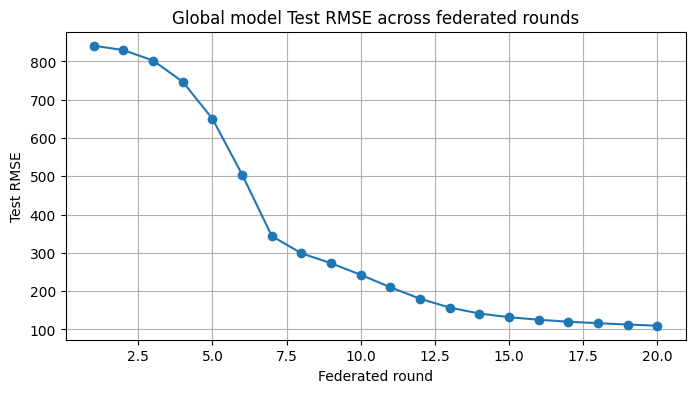

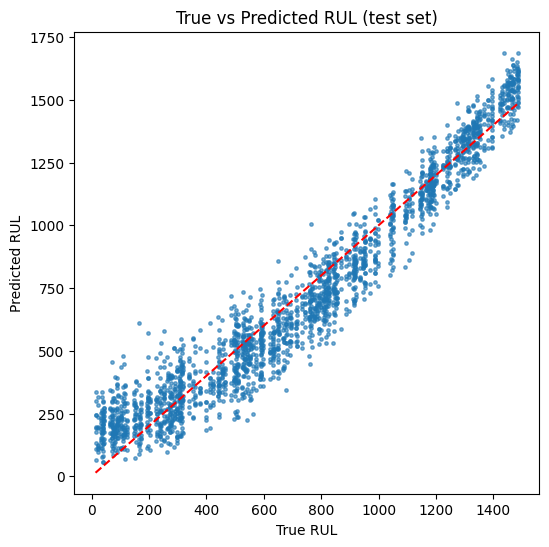

Saved model: fedavg_global_model.h5 and dataset CSV.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

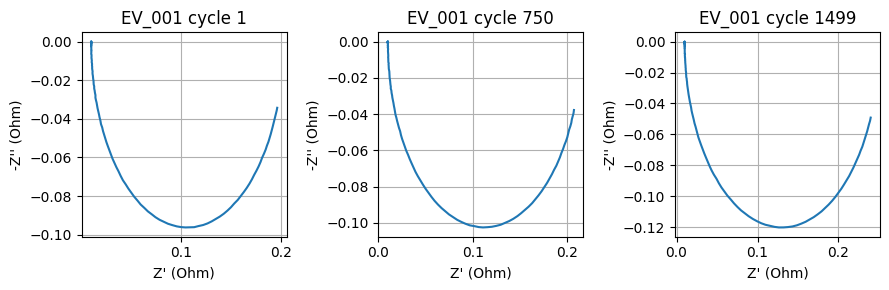

Done. You now have a synthetic dataset and a federated-training simulation.


In [ ]:
# Federated Learning simulation notebook (Keras/TensorFlow) for EV battery RUL prediction
# Run this in Google Colab (runtime: GPU optional but not required)
# Author: ChatGPT (tailored for your 10-vehicle × 1500-cycle synthetic EV dataset)

# Install / Imports

import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow version:", tf.__version__)
print("Pandas version:", pd.__version__)

# -----------------------
# 1) Synthetic dataset generator (10 vehicles × 1500 cycles)
# -----------------------
def generate_vehicle_data(vehicle_id, num_cycles=1500, seed=None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    # Decline/increase trends across cycles for aging behavior
    cycles = np.arange(1, num_cycles+1)
    # Baseline initial values per vehicle (some variability)
    base_capacity = np.random.uniform(45, 55)     # Ah
    base_rint = np.random.uniform(15, 25)         # mΩ
    base_soc_start = 100.0
    # Create features with aging trends + noise
    SoC = np.clip(np.linspace(base_soc_start, 20, num_cycles) + np.random.normal(0, 2, num_cycles), 0, 100)
    SoH = np.clip(np.linspace(100, np.random.uniform(55,75), num_cycles) + np.random.normal(0,1,num_cycles), 0, 100)
    Capacity = np.clip(np.linspace(base_capacity, base_capacity * 0.6, num_cycles) + np.random.normal(0,0.2,num_cycles), 0, None)
    V_min = np.random.normal(3.2, 0.02, num_cycles) + (cycles / num_cycles) * 0.02  # slight drift up
    V_max = np.random.normal(4.2, 0.02, num_cycles) - (cycles / num_cycles) * 0.01  # slight drift down
    R_int = base_rint + (cycles / num_cycles) * np.random.uniform(30, 70) + np.random.normal(0,1,num_cycles)
    I_chg = np.random.normal(10, 1.0, num_cycles)  # typical currents for 2-wheeler pack (amps scale)
    I_dis = np.random.normal(8, 1.0, num_cycles)
    T_chg = np.clip(np.linspace(10, 25, num_cycles) + np.random.normal(0,1,num_cycles), 2, None)  # minutes
    T_dis = np.clip(np.linspace(30, 20, num_cycles) + np.random.normal(0,1,num_cycles), 1, None)   # minutes
    Batt_Temp = np.random.normal(30, 3, num_cycles) + (cycles/num_cycles)*3
    Amb_Temp = np.random.normal(28, 4, num_cycles)
    DoD = np.clip(np.random.normal(90, 5, num_cycles), 50, 100)  # deep cycles common
    # EIS features: small impedance values that increase slightly with aging
    EIS_f1 = np.random.uniform(0.010, 0.015, num_cycles) + (cycles/num_cycles)*0.005
    EIS_f2 = np.random.uniform(0.015, 0.022, num_cycles) + (cycles/num_cycles)*0.006
    EIS_f3 = np.random.uniform(0.020, 0.030, num_cycles) + (cycles/num_cycles)*0.007
    # RUL: remaining cycles until 1500 (label)
    RUL = (num_cycles - cycles).astype(int)
    # Build DataFrame
    df = pd.DataFrame({
        "Cycle_Index": cycles.astype(int),
        "Vehicle_ID": [f"EV_{vehicle_id:03d}"] * num_cycles,
        "SoC": SoC,
        "SoH": SoH,
        "Capacity": Capacity,
        "V_min": V_min,
        "V_max": V_max,
        "R_int": R_int,
        "I_chg": I_chg,
        "I_dis": I_dis,
        "T_chg_min": T_chg,    # minutes
        "T_dis_min": T_dis,    # minutes
        "Batt_Temp_C": Batt_Temp,
        "Amb_Temp_C": Amb_Temp,
        "DoD": DoD,
        "EIS_f1": EIS_f1,
        "EIS_f2": EIS_f2,
        "EIS_f3": EIS_f3,
        "RUL": RUL
    })
    return df

# Generate for 10 vehicles
vehicles = 10
num_cycles = 1500
list_dfs = []
for v in range(1, vehicles+1):
    df_v = generate_vehicle_data(v, num_cycles=num_cycles, seed=42 + v)
    list_dfs.append(df_v)
dataset = pd.concat(list_dfs, ignore_index=True)
print("Dataset shape:", dataset.shape)
display(dataset.head(3))

# Save dataset to CSV (Colab: saves to /content)
dataset.to_csv("synthetic_ev_battery_dataset_10vehicles_1500cycles.csv", index=False)
print("Saved: synthetic_ev_battery_dataset_10vehicles_1500cycles.csv")

# -----------------------
# 2) Prepare features and per-client splits
# -----------------------
# We'll use the following numeric features to predict RUL
FEATURE_COLS = ["Cycle_Index", "SoC", "SoH", "Capacity", "V_min", "V_max",
                "R_int", "I_chg", "I_dis", "T_chg_min", "T_dis_min",
                "Batt_Temp_C", "Amb_Temp_C", "DoD", "EIS_f1", "EIS_f2", "EIS_f3"]

TARGET = "RUL"

# Split dataset into global train / test first (stratified by vehicle)
train_dfs = []
test_dfs = []
for vid, g in dataset.groupby("Vehicle_ID"):
    tr, te = train_test_split(g, test_size=0.15, random_state=123, shuffle=True)
    train_dfs.append(tr)
    test_dfs.append(te)
train_df = pd.concat(train_dfs).reset_index(drop=True)
test_df  = pd.concat(test_dfs).reset_index(drop=True)
print("Train shape:", train_df.shape, "Test shape:", test_df.shape)

# Standardize features (fit on train)
scaler = StandardScaler()
scaler.fit(train_df[FEATURE_COLS])
def scale_df(df):
    X = scaler.transform(df[FEATURE_COLS])
    y = df[TARGET].values.astype(np.float32)
    return X.astype(np.float32), y

X_test, y_test = scale_df(test_df)

# Build per-client datasets (list of (X,y) for each client)
clients = sorted(train_df["Vehicle_ID"].unique())
client_data = {}
for vid in clients:
    df_v = train_df[train_df["Vehicle_ID"] == vid]
    X_v, y_v = scale_df(df_v)
    client_data[vid] = (X_v, y_v)
    print(vid, X_v.shape, y_v.shape)

# -----------------------
# 3) Build Keras model factory (small MLP)
# -----------------------
def build_model(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="linear")
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse",
                  metrics=[keras.metrics.RootMeanSquaredError()])
    return model

# -----------------------
# 4) Federated training loop (simple FedAvg)
# -----------------------
num_rounds = 20            # federated rounds
local_epochs = 2           # local epochs per client per round
batch_size = 128

input_dim = len(FEATURE_COLS)
global_model = build_model(input_dim)
global_weights = global_model.get_weights()

train_loss_history = []
val_rmse_history = []

for rnd in range(1, num_rounds+1):
    print(f"\n--- Federated Round {rnd}/{num_rounds} ---")
    client_weights = []
    client_sizes = []
    # For each client: create local model, set global weights, train, return weights
    for vid in clients:
        X_v, y_v = client_data[vid]
        local_model = build_model(input_dim)
        local_model.set_weights(global_weights)
        # local training
        history = local_model.fit(X_v, y_v, epochs=local_epochs, batch_size=batch_size, verbose=0)
        client_weights.append(local_model.get_weights())
        client_sizes.append(X_v.shape[0])
    # Weighted averaging of client weights (FedAvg)
    total_size = np.sum(client_sizes)
    new_weights = []
    for weights_list_tuple in zip(*client_weights):
        # weights_list_tuple is a tuple of arrays from each client for this layer
        averaged = np.zeros_like(weights_list_tuple[0], dtype=np.float32)
        for w, sz in zip(weights_list_tuple, client_sizes):
            averaged += (w * (sz / total_size))
        new_weights.append(averaged)
    global_weights = new_weights
    global_model.set_weights(global_weights)

    # Evaluate global model on test set
    loss, rmse = global_model.evaluate(X_test, y_test, verbose=0)
    print(f"Round {rnd} - Test RMSE: {rmse:.3f} (MSE loss: {loss:.3f})")
    train_loss_history.append(loss)
    val_rmse_history.append(rmse)

# -----------------------
# 5) Final evaluation & plots
# -----------------------
# Predictions on test set
y_pred = global_model.predict(X_test).flatten()

# Compute simple metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
print("\nFinal metrics on test set:")
print(f"MSE: {mse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

# Plot RMSE over rounds
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, num_rounds+1), val_rmse_history, marker='o')
plt.title("Global model Test RMSE across federated rounds")
plt.xlabel("Federated round")
plt.ylabel("Test RMSE")
plt.grid(True)
plt.show()

# Scatter: true vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=6, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("True vs Predicted RUL (test set)")
plt.show()

# -----------------------
# 6) Save model & dataset for download (Colab)
# -----------------------
global_model.save("fedavg_global_model.h5")
dataset.to_csv("synthetic_ev_battery_dataset_10vehicles_1500cycles.csv", index=False)
print("Saved model: fedavg_global_model.h5 and dataset CSV.")

# If running in Colab, you can download using:
try:
    from google.colab import files
    files.download("synthetic_ev_battery_dataset_10vehicles_1500cycles.csv")
    files.download("fedavg_global_model.h5")
except Exception as e:
    print("Not running in Colab or download failed:", e)

# -----------------------
# 7) OPTIONAL: Plot example Nyquist-like EIS curves for a few cycles (synthetic)
# -----------------------
def synthetic_nyquist(EIS_base, noise_level=1e-4):
    # produce synthetic semicircle-like data for Nyquist (Z' vs -Z'')
    freqs = np.logspace(1, 5, 200)
    # simple RC semicircle: Z' = R0 + Rct/(1+(w*tau)^2), Z'' = Rct * (w*tau)/(1+(w*tau)**2)
    R0 = 0.01
    Rct = EIS_base * 10  # scale
    tau = 1e-3 + EIS_base * 0.1
    w = 2 * np.pi * freqs
    Zp = R0 + Rct / (1 + (w * tau)**2)
    Zpp = Rct * (w * tau) / (1 + (w * tau)**2)
    # add a bit of noise
    Zp += np.random.normal(0, noise_level, Zp.shape)
    Zpp += np.random.normal(0, noise_level/2, Zpp.shape)
    return Zp, Zpp

# pick 3 cycles from vehicle 1 at early, mid, late cycle
example_vid = "EV_001"
df1 = dataset[dataset["Vehicle_ID"] == example_vid]
cycles_to_plot = [1, 750, 1499]
plt.figure(figsize=(9,3))
for i,c in enumerate(cycles_to_plot,1):
    row = df1[df1["Cycle_Index"]==c].iloc[0]
    Zp, Zpp = synthetic_nyquist(row["EIS_f2"])
    plt.subplot(1,3,i)
    plt.plot(Zp, -Zpp)
    plt.title(f"{example_vid} cycle {c}")
    plt.xlabel("Z' (Ohm)")
    plt.ylabel("-Z'' (Ohm)")
    plt.grid(True)
plt.tight_layout()
plt.show()

print("Done. You now have a synthetic dataset and a federated-training simulation.")


In [ ]:
import joblib

# Assuming 'scaler' is the StandardScaler object from your training script
# scaler.fit(train_df[FEATURE_COLS]) was already run

# Save the scaler to a file
joblib.dump(scaler, 'my_scaler.gz')

print("Scaler saved successfully as my_scaler.gz")

Scaler saved successfully as my_scaler.gz


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import os

# --- Configuration: Define filenames and feature columns ---

MODEL_FILE = 'fedavg_global_model.h5'
SCALER_FILE = 'my_scaler.gz'
# Updated to match the file in your screenshot
NEW_DATA_FILE = '/content/synthetic_ev_battery_dataset_10vehicles_1500cycles.csv'
RESULTS_FILE = 'prediction_results.csv' # This file will be created with the results.

# This list MUST be the exact same 17 features used for training, in the same order.
FEATURE_COLS = [
    "Cycle_Index", "SoC", "SoH", "Capacity", "V_min", "V_max",
    "R_int", "I_chg", "I_dis", "T_chg_min", "T_dis_min",
    "Batt_Temp_C", "Amb_Temp_C", "DoD", "EIS_f1", "EIS_f2", "EIS_f3"
]

# --- 1. Load the Model and Scaler ---
print("--- Step 1: Loading model and scaler ---")

# Check if all required files exist before proceeding
if not all(os.path.exists(f) for f in [MODEL_FILE, SCALER_FILE, NEW_DATA_FILE]):
    print("❌ ERROR: One or more required files are missing!")
    print(f"Please make sure you have uploaded '{MODEL_FILE}', '{SCALER_FILE}', and '{NEW_DATA_FILE}'.")
else:
    try:
        # ---- THIS IS THE CORRECTED LINE ----
        # Load the model for inference only, skipping the training configuration.
        model = tf.keras.models.load_model(MODEL_FILE, compile=False)
        # ------------------------------------

        scaler = joblib.load(SCALER_FILE)
        print("✅ Model and scaler loaded successfully.\n")

        # --- 2. Load and Prepare the New Dataset ---
        print("--- Step 2: Loading and preparing new data ---")
        new_df = pd.read_csv(NEW_DATA_FILE)
        print(f"Loaded {len(new_df)} rows from '{NEW_DATA_FILE}'.")

        # Extract features in the correct order
        new_features = new_df[FEATURE_COLS]

        # Scale the features using the previously fitted scaler
        scaled_new_features = scaler.transform(new_features)
        print("✅ New data has been scaled successfully.\n")

        # --- 3. Make Predictions ---
        print("--- Step 3: Making RUL predictions ---")
        predicted_rul = model.predict(scaled_new_features)
        print("✅ Predictions complete.\n")

        # --- 4. Display and Save Results ---
        print("--- Step 4: Finalizing results ---")
        new_df['Predicted_RUL'] = predicted_rul.flatten().astype(int)

        new_df.to_csv(RESULTS_FILE, index=False)
        print(f"✅ Results saved to '{RESULTS_FILE}'. You can download this file from the Colab file panel.")

        print("\n--- Comparison of Actual vs. Predicted RUL (First 15 Rows) ---")
        print(new_df[['Vehicle_ID', 'Cycle_Index', 'RUL', 'Predicted_RUL']].head(15))

    except Exception as e:
        print(f"An error occurred: {e}")
        print("Please check if your model, scaler, and data files are valid and not corrupted.")

--- Step 1: Loading model and scaler ---
✅ Model and scaler loaded successfully.

--- Step 2: Loading and preparing new data ---
Loaded 15000 rows from '/content/synthetic_ev_battery_dataset_10vehicles_1500cycles.csv'.
✅ New data has been scaled successfully.

--- Step 3: Making RUL predictions ---
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
✅ Predictions complete.

--- Step 4: Finalizing results ---
✅ Results saved to 'prediction_results.csv'. You can download this file from the Colab file panel.

--- Comparison of Actual vs. Predicted RUL (First 15 Rows) ---
   Vehicle_ID  Cycle_Index   RUL  Predicted_RUL
0      EV_001            1  1499           1497
1      EV_001            2  1498           1408
2      EV_001            3  1497           1527
3      EV_001            4  1496           1545
4      EV_001            5  1495           1487
5      EV_001            6  1494           1503
6      EV_001            7  1493           1511
7      EV_001            8  1492           1518
8   

--- Step 1: Loading and preparing data ---
✅ Successfully loaded 15000 rows from 'unsupervised_battery_data.csv'.

--- Step 2: Defining 'healthy' data (first 10.0% of cycles) ---
✅ Created a training set of 1500 'healthy' data points.

--- Step 3: Building the Autoencoder model ---
✅ Model built successfully.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 17)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 649 (2.54 KB)

 Trainable params: 649 (2.54 KB)

 Non-trainable params: 0 (0.00 B)


--- Step 4: Training the model ONLY on healthy data ---
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 1.1375 - val_loss: 1.1149
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1184 - val_loss: 1.0716
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0645 - val_loss: 1.0068
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.9978 - val_loss: 0.9453
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9442 - val_loss: 0.9088
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9050 - val_loss: 0.8949
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8973 - val_loss: 0.8893
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8930 - val_loss: 0.8864
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8914 - val_loss: 0.8842
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8859 - val_loss: 0.8820
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8830 - val_loss: 0.8796
Epoch 12/50


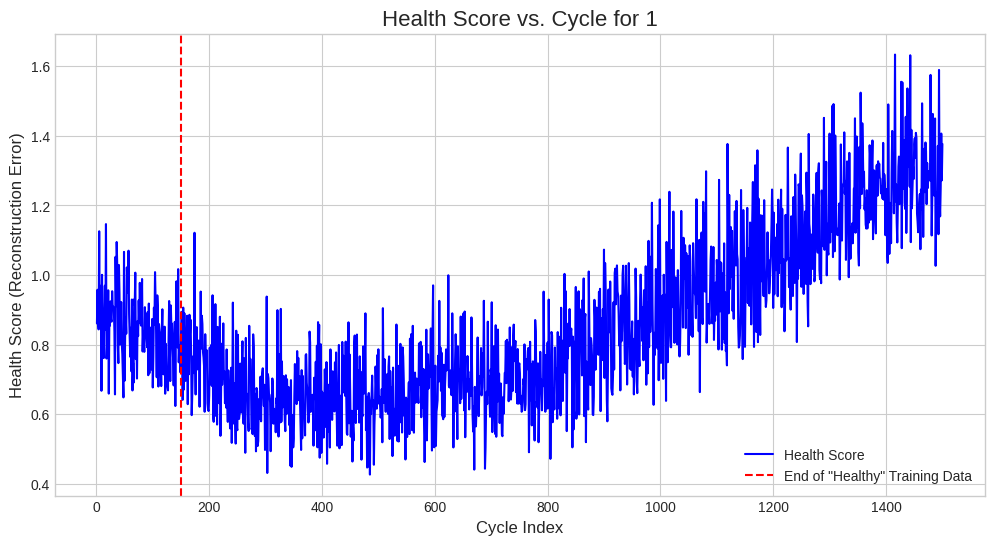


--- Interpretation ---
Notice how the 'Health Score' is low and stable during the early cycles the model was trained on.
As the battery degrades over more cycles, the model struggles to reconstruct the 'unhealthy' data, causing the score to rise.
This rising score is your indicator of a degrading battery!


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- Configuration ---
DATA_FILE = 'unsupervised_battery_data.csv'
RESULTS_FILE = 'health_score_results.csv'

# IMPORTANT: Ensure your CSV file has these exact column names.
# Based on your previous dataset file. 'Vehicle_ID' is used for grouping, not for training.
FEATURE_COLS = [
    "Cycle_Index", "SoC", "SoH", "Capacity", "V_min", "V_max",
    "R_int", "I_chg", "I_dis", "T_chg_min", "T_dis_min",
    "Batt_Temp_C", "Amb_Temp_C", "DoD", "EIS_f1", "EIS_f2", "EIS_f3"
]

# We'll define "healthy" as the first 10% of cycles for each vehicle.
HEALTHY_STATE_THRESHOLD = 0.10

# --- 1. Load and Prepare the Data ---
print("--- Step 1: Loading and preparing data ---")
try:
    df = pd.read_csv(DATA_FILE)
    print(f"✅ Successfully loaded {len(df)} rows from '{DATA_FILE}'.")
except FileNotFoundError:
    print(f"❌ ERROR: File not found! Please upload your data and name it '{DATA_FILE}'.")
    exit()

# Scale the features
# Scaling is crucial for neural networks to perform well.
scaler = StandardScaler()
df_features_scaled = scaler.fit_transform(df[FEATURE_COLS])
df_features_scaled = pd.DataFrame(df_features_scaled, columns=FEATURE_COLS)

# --- 2. Isolate "Healthy" Data for Training ---
print(f"\n--- Step 2: Defining 'healthy' data (first {HEALTHY_STATE_THRESHOLD*100}% of cycles) ---")
healthy_data_list = []
for vid in df['Vehicle_ID'].unique():
    vehicle_df = df[df['Vehicle_ID'] == vid]
    healthy_cycle_limit = int(vehicle_df['Cycle_Index'].max() * HEALTHY_STATE_THRESHOLD)
    healthy_df = df_features_scaled[df['Vehicle_ID'] == vid].iloc[:healthy_cycle_limit]
    healthy_data_list.append(healthy_df)

train_df = pd.concat(healthy_data_list)
print(f"✅ Created a training set of {len(train_df)} 'healthy' data points.")

# --- 3. Build the Autoencoder Model ---
# This model learns to perfectly reconstruct only "healthy" data.
print("\n--- Step 3: Building the Autoencoder model ---")
input_dim = len(FEATURE_COLS)

autoencoder = keras.Sequential([
    # Encoder part
    layers.Input(shape=(input_dim,)),
    layers.Dense(12, activation='relu'),
    layers.Dense(8, activation='relu'), # Bottleneck layer (compressed representation)

    # Decoder part
    layers.Dense(12, activation='relu'),
    layers.Dense(input_dim, activation='sigmoid') # Reconstruct the original data
])

autoencoder.compile(optimizer='adam', loss='mae') # Mean Absolute Error
print("✅ Model built successfully.")
autoencoder.summary()

# --- 4. Train the Model ---
print("\n--- Step 4: Training the model ONLY on healthy data ---")
history = autoencoder.fit(
    train_df, train_df,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_split=0.1, # Use 10% of healthy data to check for overfitting
    verbose=1
)

# --- 5. Calculate Health Score for ALL Data ---
print("\n--- Step 5: Calculating 'Health Score' for the entire dataset ---")
# Get the model's reconstructions of the entire dataset
reconstructions = autoencoder.predict(df_features_scaled)

# The "Health Score" is the error between the original data and the model's reconstruction.
# A high error means the data is "anomalous" or "unhealthy".
reconstruction_error = tf.keras.losses.mae(reconstructions, df_features_scaled)

# Add the Health Score to our original dataframe
df['Health_Score'] = reconstruction_error
print("✅ Health Score calculated and added to the dataframe.")

# --- 6. Save and Visualize Results ---
print("\n--- Step 6: Saving results and visualizing the Health Score ---")
df.to_csv(RESULTS_FILE, index=False)
print(f"✅ Complete results with Health Score saved to '{RESULTS_FILE}'.")

# Display the results for the first vehicle
print("\nDisplaying results for the first vehicle...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the health score over the cycles for one vehicle
vehicle_to_plot = df['Vehicle_ID'].unique()[0]
vehicle_data = df[df['Vehicle_ID'] == vehicle_to_plot]

ax.plot(vehicle_data['Cycle_Index'], vehicle_data['Health_Score'], color='b', label='Health Score')
ax.set_title(f'Health Score vs. Cycle for {vehicle_to_plot}', fontsize=16)
ax.set_xlabel('Cycle Index', fontsize=12)
ax.set_ylabel('Health Score (Reconstruction Error)', fontsize=12)

# Highlight the point where health starts to clearly degrade
degradation_start_point = vehicle_data['Cycle_Index'].max() * HEALTHY_STATE_THRESHOLD
ax.axvline(x=degradation_start_point, color='r', linestyle='--', label=f'End of "Healthy" Training Data')
ax.legend()
plt.show()

print("\n--- Interpretation ---")
print("Notice how the 'Health Score' is low and stable during the early cycles the model was trained on.")
print("As the battery degrades over more cycles, the model struggles to reconstruct the 'unhealthy' data, causing the score to rise.")
print("This rising score is your indicator of a degrading battery!")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the results file you just created
RESULTS_FILE = 'health_score_results.csv'
df = pd.read_csv(RESULTS_FILE)

# Create a directory to save the plots
if not os.path.exists('vehicle_plots'):
    os.makedirs('vehicle_plots')

print("--- Generating plots for each vehicle ---")

for vehicle_id in df['Vehicle_ID'].unique():
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 6))

    vehicle_data = df[df['Vehicle_ID'] == vehicle_id]

    ax.plot(vehicle_data['Cycle_Index'], vehicle_data['Health_Score'], color='b', label='Health Score')
    ax.set_title(f'Health Score vs. Cycle for {vehicle_id}', fontsize=16)
    ax.set_xlabel('Cycle Index', fontsize=12)
    ax.set_ylabel('Health Score (Reconstruction Error)', fontsize=12)

    # Mark the end of the "healthy" training period
    degradation_start_point = vehicle_data['Cycle_Index'].max() * 0.10
    ax.axvline(x=degradation_start_point, color='r', linestyle='--', label='End of "Healthy" Training Data')
    ax.legend()

    # Save the figure
    plt.savefig(f'vehicle_plots/{vehicle_id}_health_score.png')
    plt.close() # Close the plot to avoid displaying all 10 at once in the notebook

print(f"✅ All 10 vehicle plots have been saved to the 'vehicle_plots' directory.")

--- Generating plots for each vehicle ---
✅ All 10 vehicle plots have been saved to the 'vehicle_plots' directory.


✅ Calculated smoothed health score.


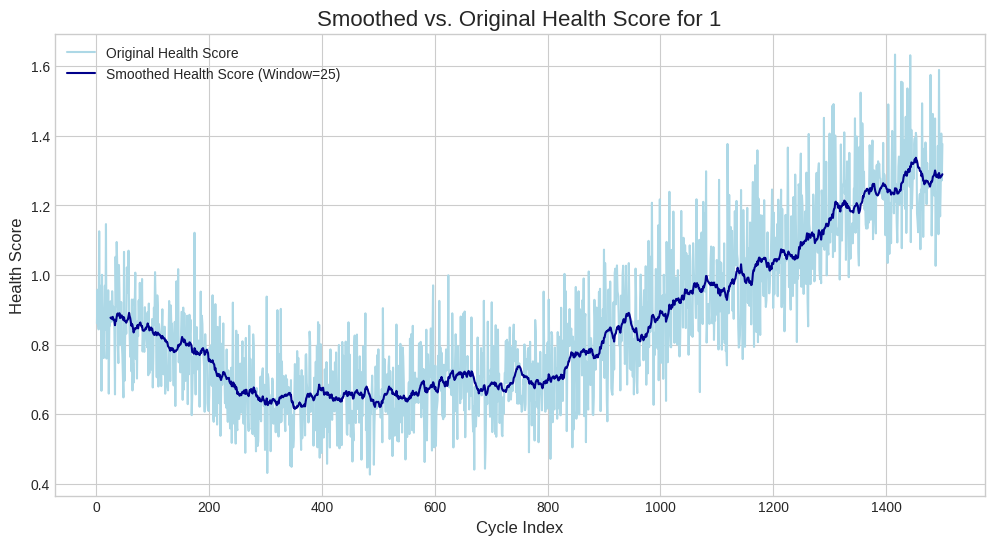

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

RESULTS_FILE = 'health_score_results.csv'
df = pd.read_csv(RESULTS_FILE)

# --- Calculate the moving average ---
# A 'window' of 25 means each point is the average of the 25 previous points.
window_size = 25
df['Smoothed_Health_Score'] = df.groupby('Vehicle_ID')['Health_Score'].transform(lambda x: x.rolling(window_size).mean())

print("✅ Calculated smoothed health score.")

# --- Plot the comparison for the first vehicle ---
vehicle_to_plot = df['Vehicle_ID'].unique()[0]
vehicle_data = df[df['Vehicle_ID'] == vehicle_to_plot]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(vehicle_data['Cycle_Index'], vehicle_data['Health_Score'], color='lightblue', label='Original Health Score')
ax.plot(vehicle_data['Cycle_Index'], vehicle_data['Smoothed_Health_Score'], color='darkblue', label=f'Smoothed Health Score (Window={window_size})')
ax.set_title(f'Smoothed vs. Original Health Score for {vehicle_to_plot}', fontsize=16)
ax.set_xlabel('Cycle Index', fontsize=12)
ax.set_ylabel('Health Score', fontsize=12)
ax.legend()
plt.show()

In [ ]:
import pandas as pd

RESULTS_FILE = 'health_score_results.csv'
df = pd.read_csv(RESULTS_FILE)

# Isolate the "healthy" data (the first 10% of cycles)
healthy_df = df[df['Cycle_Index'] <= 150]

# Calculate the threshold
mean_healthy_error = healthy_df['Health_Score'].mean()
std_healthy_error = healthy_df['Health_Score'].std()
# A common statistical threshold is Mean + 3 * Standard Deviations
anomaly_threshold = mean_healthy_error + 3 * std_healthy_error

print(f"--- Anomaly Threshold Definition ---")
print(f"Mean score on healthy data: {mean_healthy_error:.4f}")
print(f"Std Dev on healthy data:  {std_healthy_error:.4f}")
print(f"Anomaly Threshold set at:   {anomaly_threshold:.4f} (Mean + 3*StdDev)")

# Find the first time each vehicle crosses this threshold
first_alert = df[df['Health_Score'] > anomaly_threshold].groupby('Vehicle_ID')['Cycle_Index'].min()

print("\n--- 'First Alert' triggered at the following cycles: ---")
print(first_alert)

--- Anomaly Threshold Definition ---
Mean score on healthy data: 0.8489
Std Dev on healthy data:  0.1109
Anomaly Threshold set at:   1.1815 (Mean + 3*StdDev)

--- 'First Alert' triggered at the following cycles: ---
Vehicle_ID
1      985
2      965
3       83
4       28
5     1073
6       37
7     1014
8        4
9     1028
10    1011
Name: Cycle_Index, dtype: int64


✅ Created a new dataset with Health_Score and the true RUL answers.
Split data into 12000 training samples and 3000 testing samples.

--- Training a new, simple model to predict RUL from Health Score ---
✅ Model training complete.

--- Evaluating the new model's performance ---
Mean Absolute Error (MAE): 246.82 cycles
R-squared (R2) Score:      0.468

Interpretation: On average, our new model's RUL prediction is off by about 247 cycles. The R2 score of 0.468 indicates a strong fit.

--- Visualizing the relationship between Health Score and RUL ---


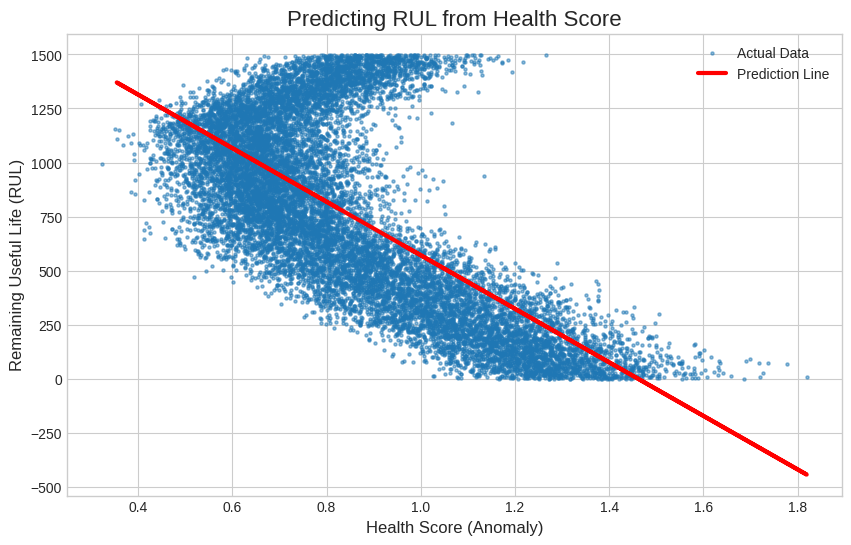

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --- Step 1: Create the "Answer Key" Dataset ---
# We need data with BOTH Health_Score and the true RUL to train our new model.

# Load the results from our unsupervised model (contains Health_Score)
HEALTH_SCORE_FILE = 'health_score_results.csv'
# Load the original dataset (contains the true RUL)
ORIGINAL_DATA_FILE = 'synthetic_ev_battery_dataset_10vehicles_1500cycles.csv'

df_health = pd.read_csv(HEALTH_SCORE_FILE)
df_original = pd.read_csv(ORIGINAL_DATA_FILE)

# Create our new training dataset by combining the Health_Score and the true RUL
# This is our "textbook" for the new model.
df_training = pd.DataFrame({
    'Health_Score': df_health['Health_Score'],
    'RUL': df_original['RUL']
})

print("✅ Created a new dataset with Health_Score and the true RUL answers.")

# --- Step 2: Prepare for Supervised Learning ---
# We will use the Health_Score as our single feature (X) to predict the RUL (y).

X = df_training[['Health_Score']] # Feature must be a 2D array
y = df_training['RUL']            # Target

# Split the data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Split data into {len(X_train)} training samples and {len(X_test)} testing samples.")

# --- Step 3: Train the Simple RUL Prediction Model ---
print("\n--- Training a new, simple model to predict RUL from Health Score ---")

# We use a Linear Regression model, which finds the best straight line
# to connect Health_Score and RUL.
rul_predictor_model = LinearRegression()
rul_predictor_model.fit(X_train, y_train)

print("✅ Model training complete.")

# --- Step 4: Evaluate the New Model ---
print("\n--- Evaluating the new model's performance ---")
y_pred = rul_predictor_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f} cycles")
print(f"R-squared (R2) Score:      {r2:.3f}")
print("\nInterpretation: On average, our new model's RUL prediction is off by about",
      f"{mae:.0f} cycles. The R2 score of {r2:.3f} indicates a strong fit.")


# --- Step 5: Visualize the Relationship ---
print("\n--- Visualizing the relationship between Health Score and RUL ---")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
plt.scatter(X, y, s=5, alpha=0.5, label='Actual Data')
plt.plot(X_test, y_pred, color='red', linewidth=3, label='Prediction Line')
plt.title('Predicting RUL from Health Score', fontsize=16)
plt.xlabel('Health Score (Anomaly)', fontsize=12)
plt.ylabel('Remaining Useful Life (RUL)', fontsize=12)
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --- Step 1: Create the "Answer Key" Dataset ---
HEALTH_SCORE_FILE = 'health_score_results.csv'
ORIGINAL_DATA_FILE = 'synthetic_ev_battery_dataset_10vehicles_1500cycles.csv'
# This is the new file we will create at the end
FINAL_PREDICTIONS_FILE = 'final_RUL_predictions.csv'

df_health = pd.read_csv(HEALTH_SCORE_FILE)
df_original = pd.read_csv(ORIGINAL_DATA_FILE)

df_training = pd.DataFrame({
    'Health_Score': df_health['Health_Score'],
    'RUL': df_original['RUL']
})
print("✅ Created a new dataset with Health_Score and the true RUL answers.")

# --- Step 2 & 3: Train the RUL Prediction Model (Same as before) ---
X = df_training[['Health_Score']]
y = df_training['RUL']

rul_predictor_model = LinearRegression()
rul_predictor_model.fit(X, y) # Train the model on ALL available data

print("✅ Model training complete.")

# --- NEW STEP 4: Predict RUL for the ENTIRE Dataset ---
print("\n--- Predicting RUL for all 15,000 cycles ---")

# Use our trained model to predict the RUL using the Health_Score column
all_health_scores = df_health[['Health_Score']] # Get all health scores
final_rul_predictions = rul_predictor_model.predict(all_health_scores)

print("✅ Predictions for the entire dataset are complete.")

# --- NEW STEP 5: Save the Final CSV File ---
print("\n--- Saving the final results to a new CSV file ---")

# Create a new DataFrame for the results
results_df = pd.DataFrame({
    'Vehicle_ID': df_original['Vehicle_ID'],
    'Cycle_Index': df_original['Cycle_Index'],
    'Health_Score': df_health['Health_Score'],
    'Actual_RUL': df_original['RUL'], # Include the real RUL for comparison
    'Predicted_RUL_from_Health_Score': final_rul_predictions.astype(int)
})

# Save the DataFrame to a CSV file
results_df.to_csv(FINAL_PREDICTIONS_FILE, index=False)

print(f"✅ Success! Your file is ready.")
print(f"Please look for a new file named '{FINAL_PREDICTIONS_FILE}' in your Colab file panel on the left.")

# Display the first 15 rows of your new file
print("\n--- Here is a preview of your final file: ---")
print(results_df.head(15))

FileNotFoundError: [Errno 2] No such file or directory: 'health_score_results.csv'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')